In [38]:
import globals as gl
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PcmPy as pcm
import seaborn as sb
from globals import chord_mapping

plt.style.use('default')

In [39]:
sn = 102
path = os.path.join(gl.baseDir, gl.behavDir, f'p{sn}_testing')
palette = ['red', 'darkred', 'blue', 'darkblue']

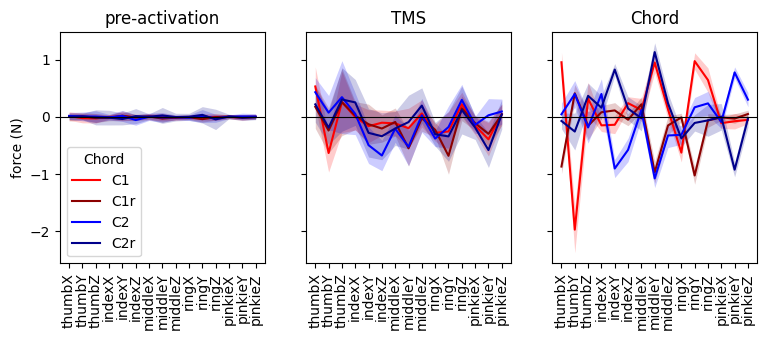

In [40]:
condition = ['pre-activation', 'TMS', 'Chord']
df = pd.read_csv(os.path.join(path, 'single_trial.tsv'), sep='\t')
df.Chord = df.Chord.map(gl.chord_mapping)
df.Chord = pd.Categorical(df.Chord, categories=list(gl.chord_mapping.values()))
df_melt = pd.melt(df, value_vars=gl.channels, var_name='channel', id_vars=['condition', 'Chord', 'TN'], value_name='force')
df_melt.channel = df_melt.channel.map(gl.channel_mapping)
df_melt_pre = pd.melt(df, value_vars=[ch + '_PRE' for ch in gl.channels], var_name='channel', id_vars=['condition', 'Chord', 'TN'], value_name='force')
df_melt_pre.channel = df_melt_pre.channel.map(gl.channel_mapping_PRE)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(9, 3))
sb.lineplot(data=df_melt_pre[df_melt_pre['condition']=='TMS'], ax=axs[0], x='channel', y='force', hue='Chord', err_kws={'linewidth': 0}, errorbar='sd', palette=palette)
sb.lineplot(data=df_melt[df_melt['condition']=='TMS'], ax=axs[1], x='channel', y='force', hue='Chord', err_kws={'linewidth': 0}, errorbar='sd', legend=False, palette=palette)
sb.lineplot(data=df_melt[df_melt['condition']=='Chord'], ax=axs[2], x='channel', y='force', hue='Chord', err_kws={'linewidth': 0}, errorbar='sd', legend=False, palette=palette)
for i, ax in enumerate(axs):
    ax.axhline(y=0, color='k', lw=.8)
    ax.set_xticks(np.arange(len(gl.channels)))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(condition[i])
    ax.set_xlabel('')

axs[0].set_ylabel('force (N)')

plt.show()

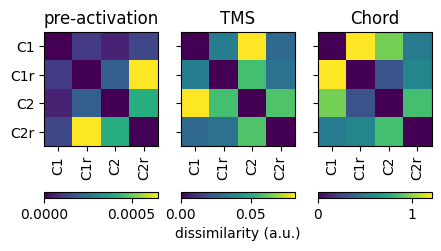

In [41]:
fig, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(5, 4))

condition = ['pre-activation', 'TMS', 'Chord']
D_avg = np.zeros(len(condition))
D_std = np.zeros(len(condition))
for c, cond in enumerate(condition):
    if cond == 'pre-activation':
        df_tmp = df[df['condition']=='TMS']
        Y = df_tmp[gl.channels_PRE].to_numpy()
    else:
        df_tmp = df[df['condition']==cond]
        Y = df_tmp[gl.channels].to_numpy()

    Y_g, cond_vec, part_vec = pcm.group_by_condition(Y, df_tmp.Chord, df_tmp.BN, axis=0)

    # dissimilarity
    G, _ = pcm.est_G_crossval(Y_g, cond_vec, part_vec,)
    D = pcm.G_to_dist(G)
    D_avg[c] = D.mean()
    D_std[c] = D.std()

    # plot
    ax = axs[c]
    ax.imshow(D,) #vmin=0, vmax=.3)
    ax.set_xticks(np.arange(4))
    ax.set_yticks(np.arange(4))
    ax.set_xticklabels(list(gl.chord_mapping.values()), rotation=90)
    ax.set_yticklabels(list(gl.chord_mapping.values()))
    ax.set_title(cond)

for i, ax in enumerate(axs):
    cax = ax.get_images()[0]
    cbar = fig.colorbar(cax, ax=ax, orientation='horizontal', fraction=.05)
    cbar.set_label('dissimilarity (a.u.)') if i == 1 else None

plt.show()

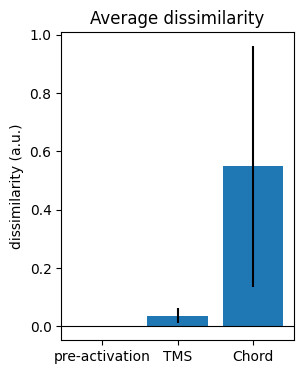

In [42]:
fig, ax = plt.subplots(figsize=(3, 4))

ax.bar(condition, D_avg, yerr=D_std)
ax.set_title('Average dissimilarity')
ax.set_ylabel('dissimilarity (a.u.)')
ax.axhline(0, color='k', lw=.8)
#ax.set_yscale('symlog', linthresh=.01)

plt.show()